In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms 

%matplotlib inline 

# 1. Load the data

In [2]:
import csv
from torch.utils.data.dataset import Dataset 

def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive')
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative')
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

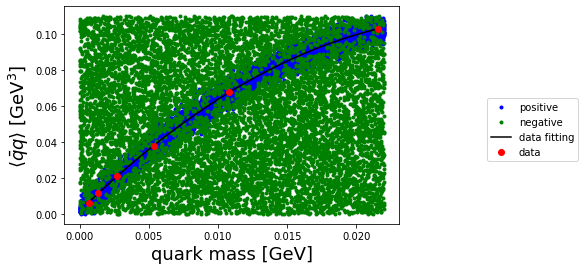

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [14]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [15]:
import torch.nn as nn 
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1
def f(phi, pi):
    return pi
def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

class MetricNet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, m2=None, 
                 del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layer = N_layer
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d
    def show_Hs(self):
        H=[]
        for i in range (N_layer):
            H.append(self.Hs[i](self.one).data.numpy()[0])
        return np.array(H)            
    def show_lamb(self):
        return self.lamb(self.one)
    def show_adsradius(self):
        return self.adsradius(self.one)
    
    def penalty(self):
        pen=0
        for i in range (self.N_layer-1):
            H1=self.Hs[i](self.one)
            H2=self.Hs[i+1](self.one)
            pen=pen+c_reg1*((eta_ini+i*del_eta)**4)*((H2-H1)**2)
        pen=pen+c_reg2*(self.d - self.Hs[0](self.one))**2
        return pen
    
    def forward(self, phi=None, pi=None):
        alpha = phi*self.adsradius(self.one)*np.sqrt(3)/(2*3.141592653589793)
        beta = pi*(self.adsradius(self.one))**3*(3.141592653589793/np.sqrt(3))
        phi = alpha*(np.exp(-self.eta_ini)) + beta*(np.exp(-3*self.eta_ini)) - (1/2)*alpha**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        pi = - alpha*(np.exp(-self.eta_ini)) - 3*beta*(np.exp(-3*self.eta_ini)) + (3/2)*alpha**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini)) - (1/2)*alpha**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        for i in range (N_layer):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        fvalue = f(phi, pi)
        final = t(fvalue)
        return final
    
    def loss(self, phi=None, pi=None, answer=None):
        model_output = self.forward(phi=phi, pi=pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty()
        return loss
    
def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w = np.random.normal(d, 3)
        w = round(w, 10)
        Model.Hs[i].weight.data.fill_(w)
    lamb = np.random.normal(0.2, 0)
    Model.lamb.weight.data.fill_(lamb)
    adsradius = np.random.normal(0.8, 0)
    Model.adsradius.weight.data.fill_(adsradius)

In [20]:
d = 4
m2 = -3
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
c_reg1=0.01
c_reg2=0.01

Test = MetricNet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()
print(Test.show_Hs())

[ 2.0584285   2.7094336   0.483302    3.9560807   6.190071    3.4241815
  6.8458037   0.49469867  5.260882    7.8401694   4.158419    2.1733954
  2.8278644  -0.11865637  6.0397673 ]


# 3. Train your NN

In [17]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, pi=Pis).data.numpy()
    for index in range(len(phis)):
        value = NN2_predicts[index]
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    
    NN2_pos_phis = []
    NN2_pos_Pis = []
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, pi=Pis).data.numpy()
    for index in range(len(phis)):
        value = NN2_predicts[index]
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)

    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, '.', label='Positive', alpha=0.5)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(n)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(p)=0')
    al.tick_params(labelsize=12)
    
    if eta_or_layer=='eta':
        del_eta = Net.del_eta
        x = np.array([1+i*del_eta for i in range (Net.N_layer)])
        ar.set_xlabel('eta')
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer')
    
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric H', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric', lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

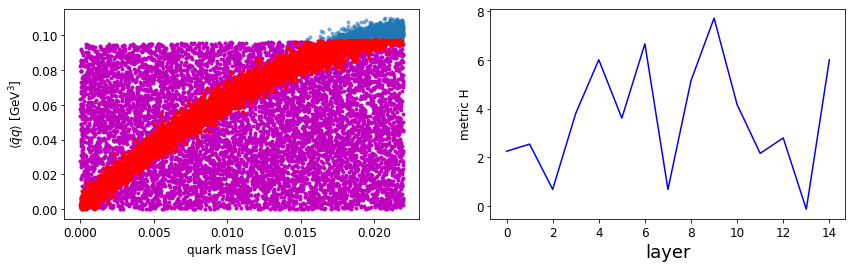

training epoch: 0,   loss: 0.5390716791152954
lambda: 0.15334376692771912,   AdS radius: 0.7750295400619507[1/GeV]
[ 2.2483256   2.5416522   0.68077505  3.8047175   6.011414    3.6141934
  6.6666603   0.6797559   5.154092    7.7255816   4.1653438   2.162607
  2.796354   -0.13660386  6.0127387 ]


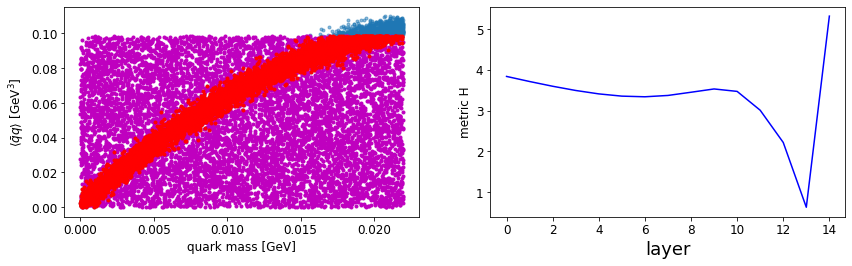

training epoch: 100,   loss: 0.2525072395801544
lambda: -2.668846845626831,   AdS radius: 0.8049619793891907[1/GeV]
[3.8387535 3.714213  3.5978696 3.4945138 3.410855  3.3557854 3.3399312
 3.372597  3.4510782 3.5317206 3.472011  3.0100863 2.220009  0.6323842
 5.317085 ]


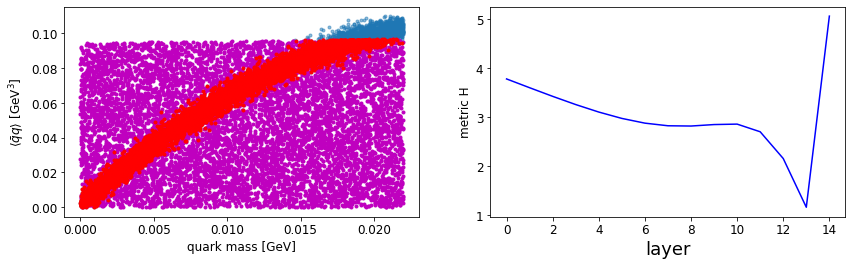

training epoch: 200,   loss: 0.2507230043411255
lambda: -5.195281982421875,   AdS radius: 0.9169082045555115[1/GeV]
[3.7746723 3.5952578 3.4192793 3.251558  3.0986276 2.968909  2.8723662
 2.8188758 2.8133569 2.8434663 2.8525653 2.696261  2.150338  1.1559446
 5.056666 ]


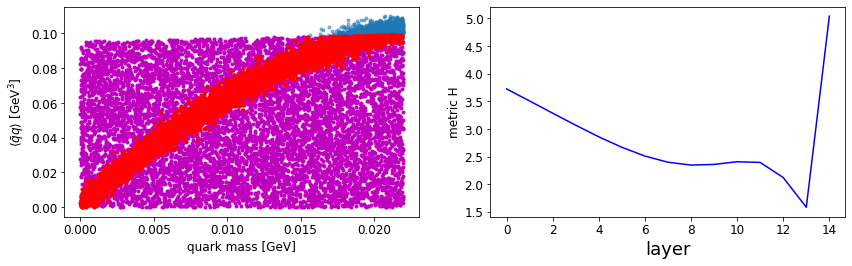

training epoch: 300,   loss: 0.24955707788467407
lambda: -7.445425033569336,   AdS radius: 1.007331132888794[1/GeV]
[3.7238524 3.5058632 3.2852476 3.0667536 2.8574758 2.6672478 2.508818
 2.3969798 2.345325  2.357374  2.4059775 2.393548  2.119325  1.5821543
 5.041782 ]


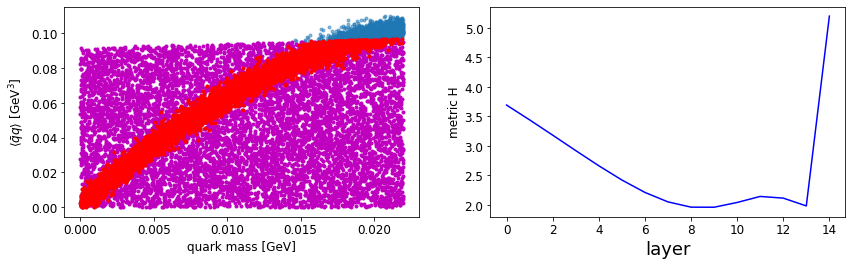

training epoch: 400,   loss: 0.2489079087972641
lambda: -9.45829963684082,   AdS radius: 1.1126046180725098[1/GeV]
[3.6922932 3.4409707 3.1820812 2.9203537 2.663302  2.4219205 2.211332
 2.0507483 1.9614177 1.9598551 2.040867  2.143049  2.114506  1.9822631
 5.1999464]


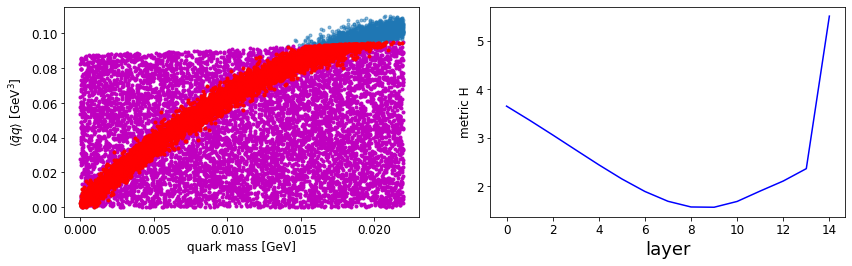

training epoch: 500,   loss: 0.24775810539722443
lambda: -11.343926429748535,   AdS radius: 1.2598230838775635[1/GeV]
[3.6503856 3.3595812 3.057252  2.748621  2.4421992 2.1507409 1.8921952
 1.6901395 1.5726341 1.5671058 1.6866288 1.9009558 2.1071913 2.3623087
 5.50488  ]


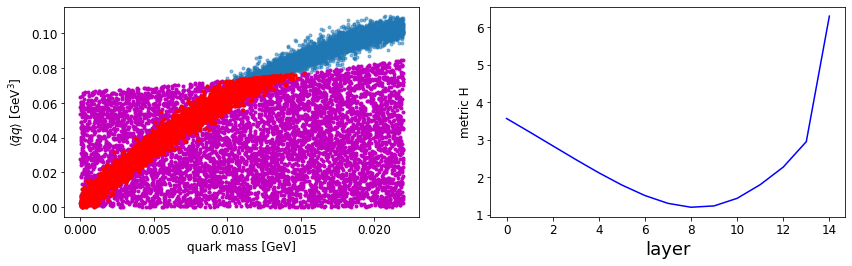

training epoch: 600,   loss: 0.2418384552001953
lambda: -12.581869125366211,   AdS radius: 1.6247146129608154[1/GeV]
[3.562989  3.2028508 2.8355522 2.4694304 2.115585  1.7886145 1.5079893
 1.2995392 1.1955388 1.2311038 1.4332476 1.7974184 2.2666194 2.9458025
 6.293852 ]


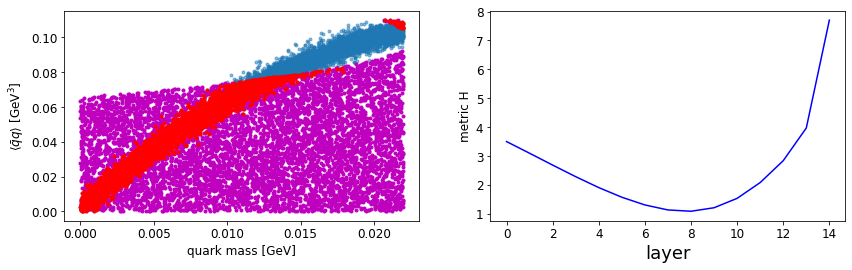

training epoch: 700,   loss: 0.23883333802223206
lambda: -12.587804794311523,   AdS radius: 1.6306250095367432[1/GeV]
[3.498318  3.0928802 2.6831486 2.2813413 1.9034731 1.5692387 1.3019528
 1.1291475 1.0840074 1.2052954 1.5305802 2.078264  2.8358161 3.9683552
 7.7059374]


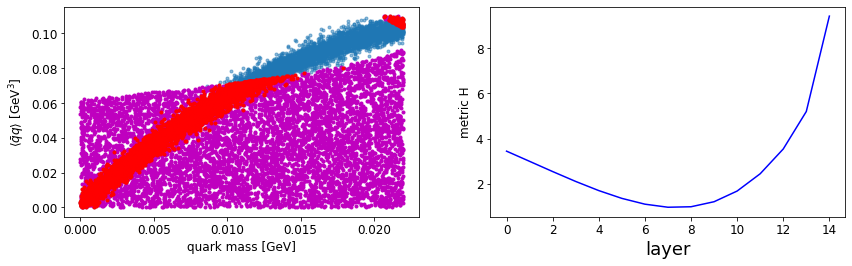

training epoch: 800,   loss: 0.2341250777244568
lambda: -12.528382301330566,   AdS radius: 1.6342343091964722[1/GeV]
[3.4426825  2.9915106  2.538725   2.0999045  1.6954389  1.3502977
 1.0934107  0.95732987 0.9791207  1.2021728  1.6749531  2.4412847
 3.5390642  5.200176   9.427101  ]


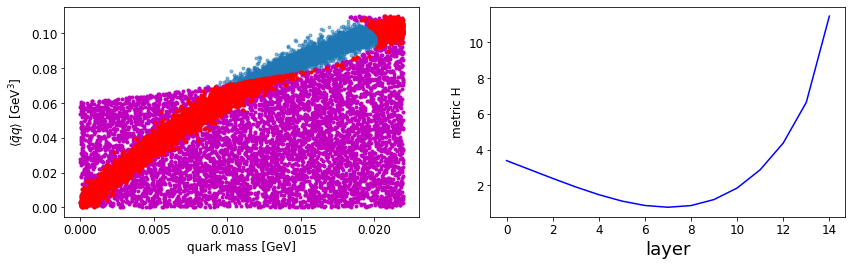

training epoch: 900,   loss: 0.2285301834344864
lambda: -12.390495300292969,   AdS radius: 1.6303431987762451[1/GeV]
[ 3.382631   2.885939   2.3899238  1.9135699  1.4817411  1.1247956
  0.8776796  0.779208   0.8728253  1.2096227  1.8517591  2.872207
  4.3657207  6.6362004 11.451453 ]


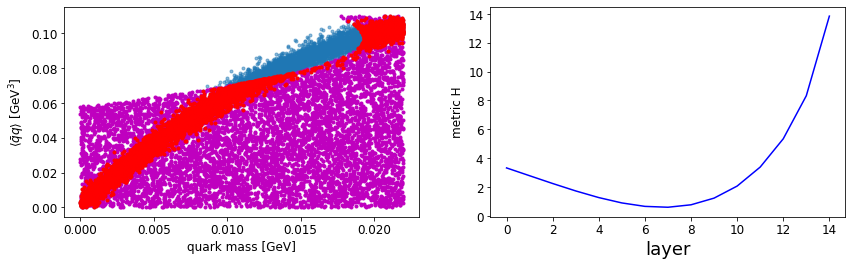

training epoch: 1000,   loss: 0.22205545008182526
lambda: -12.132180213928223,   AdS radius: 1.6187115907669067[1/GeV]
[ 3.3284507   2.7878506   2.2490544   1.7345546   1.2739885   0.9035975
  0.66508526  0.6047003   0.7743448   1.2362041   2.0708725   3.3870327
  5.345703    8.328384   13.844795  ]


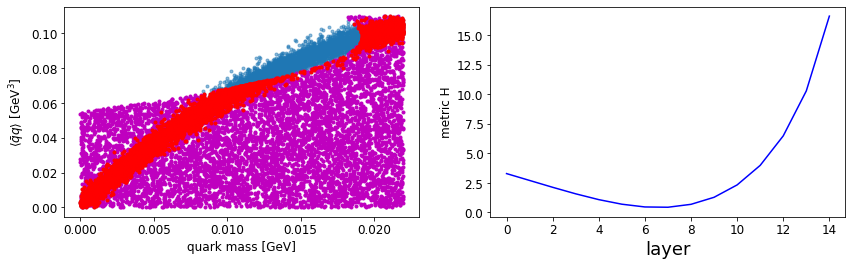

training epoch: 1100,   loss: 0.21477371454238892
lambda: -11.717061042785645,   AdS radius: 1.6016864776611328[1/GeV]
[ 3.2843192   2.70402     2.124672    1.5721668   1.0811474   0.69438016
  0.46131125  0.43704283  0.684007    1.278916    2.326359    3.9792047
  6.4759603  10.27935    16.60867   ]


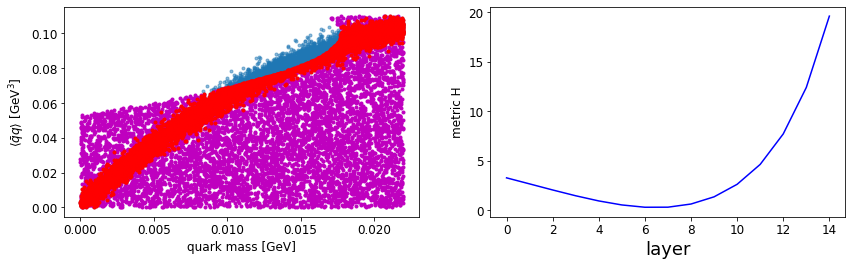

training epoch: 1200,   loss: 0.2075452208518982
lambda: -11.138017654418945,   AdS radius: 1.58076012134552[1/GeV]
[ 3.2463703   2.6336772   2.0187857   1.4304916   0.9082389   0.50165015
  0.26881373  0.27501366  0.59507364  1.3231226   2.5926487   4.608548
  7.6963735  12.400336   19.62855   ]


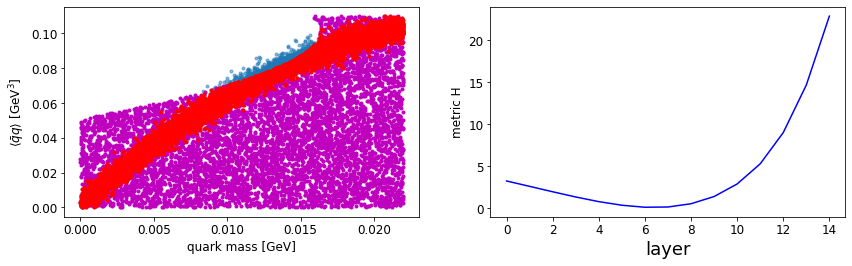

training epoch: 1300,   loss: 0.2007029950618744
lambda: -10.375937461853027,   AdS radius: 1.563057780265808[1/GeV]
[ 3.2184875   2.5808918   1.9363047   1.3155209   0.7621512   0.3325687
  0.09413309  0.12359196  0.50994563  1.3672686   2.862071    5.257701
  8.973456   14.633354   22.835484  ]


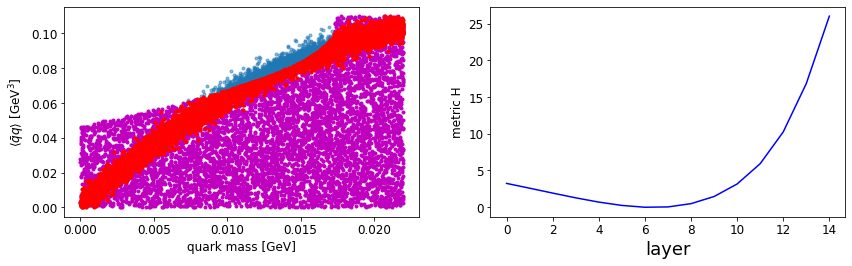

training epoch: 1400,   loss: 0.19433200359344482
lambda: -9.426268577575684,   AdS radius: 1.5505095720291138[1/GeV]
[ 3.2071035e+00  2.5516751e+00  1.8837159e+00  1.2351083e+00
  6.5262139e-01  1.9866565e-01 -5.0231744e-02 -5.2258275e-03
  4.3801573e-01  1.4149865e+00  3.1271374e+00  5.8981905e+00
  1.0239137e+01  1.6846745e+01  2.6054831e+01]


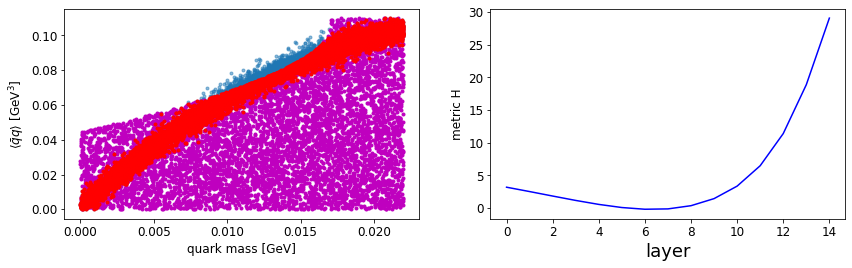

training epoch: 1500,   loss: 0.19016654789447784
lambda: -8.320035934448242,   AdS radius: 1.540640115737915[1/GeV]
[ 3.1974618   2.5300114   1.844384    1.172844    0.5643787   0.08639155
 -0.17614463 -0.12243633  0.36747825  1.4507627   3.3631647   6.4849963
 11.4075     18.889193   29.082222  ]


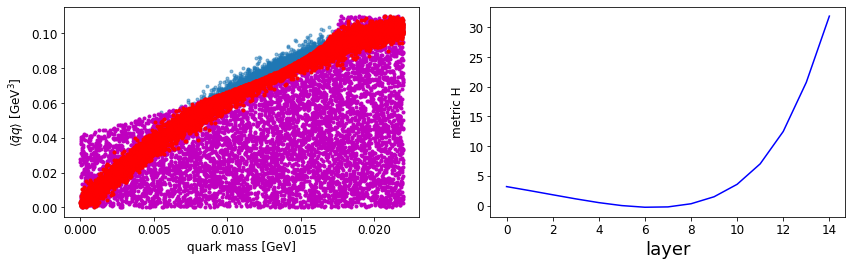

training epoch: 1600,   loss: 0.18593326210975647
lambda: -7.048299789428711,   AdS radius: 1.5414541959762573[1/GeV]
[ 3.1933916e+00  2.5175643e+00  1.8186482e+00  1.1285481e+00
  4.9751279e-01 -3.1090381e-03 -2.8078327e-01 -2.2323284e-01
  3.0506939e-01  1.4827018e+00  3.5779324e+00  7.0211473e+00
  1.2468482e+01  2.0731293e+01  3.1871332e+01]


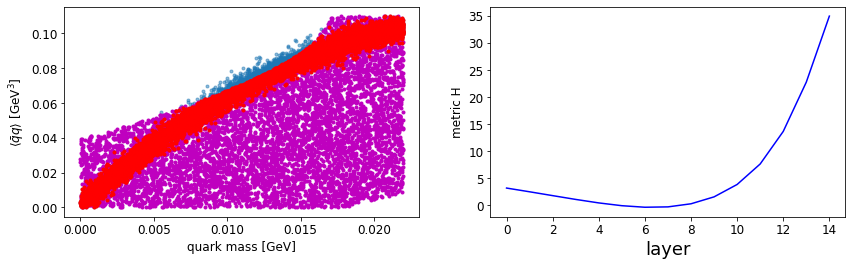

training epoch: 1700,   loss: 0.18184803426265717
lambda: -5.371201515197754,   AdS radius: 1.5656787157058716[1/GeV]
[ 3.1645548   2.4751604   1.7658286   1.0645993   0.42013487 -0.09425248
 -0.37961513 -0.31240046  0.25938478  1.5379448   3.8278341   7.615231
 13.628883   22.738289   34.930717  ]


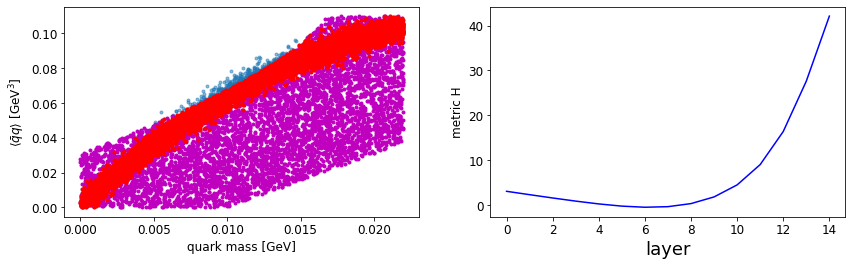

training epoch: 1800,   loss: 0.15130352973937988
lambda: -1.0681664943695068,   AdS radius: 1.804297685623169[1/GeV]
[ 3.0285275   2.2751186   1.5397339   0.83946854  0.2109659  -0.27884138
 -0.52783877 -0.398752    0.2863174   1.7753484   4.4594374   8.991461
 16.367634   27.612545   42.118034  ]


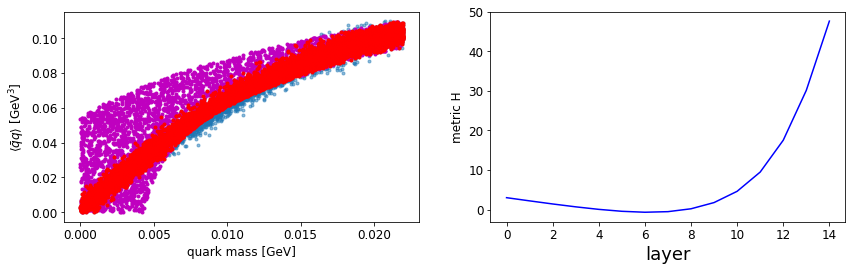

training epoch: 1900,   loss: 0.07936070114374161
lambda: 0.020719200372695923,   AdS radius: 3.3547091484069824[1/GeV]
[ 3.0113883   2.2055144   1.4220127   0.69499636  0.05732153 -0.43114212
 -0.6710693  -0.52189314  0.2041877   1.7750268   4.6228905   9.488496
 17.539091   30.151728   47.658802  ]


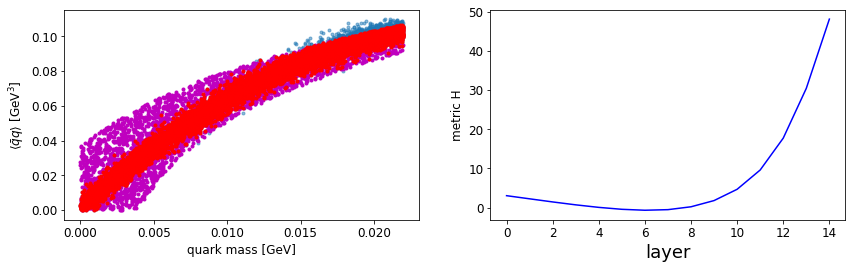

training epoch: 2000,   loss: 0.07743228226900101
lambda: 0.007043709047138691,   AdS radius: 3.7339460849761963[1/GeV]
[ 3.0359883e+00  2.2341921e+00  1.4369353e+00  6.9349104e-01
  4.5985989e-02 -4.4668427e-01 -6.8758631e-01 -5.3620160e-01
  1.9764924e-01  1.7867247e+00  4.6719294e+00  9.6054592e+00
  1.7752378e+01  3.0483311e+01  4.8190636e+01]


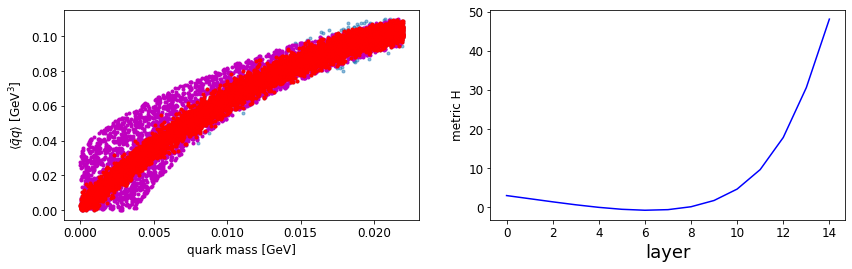

training epoch: 2100,   loss: 0.07656581699848175
lambda: 0.005108674988150597,   AdS radius: 3.798903465270996[1/GeV]
[ 3.0473707e+00  2.2501764e+00  1.4473644e+00  6.9287074e-01
  3.7012953e-02 -4.5960206e-01 -7.0156896e-01 -5.4873204e-01
  1.9075060e-01  1.7932082e+00  4.7053890e+00  9.6848822e+00
  1.7882179e+01  3.0609184e+01  4.8123325e+01]


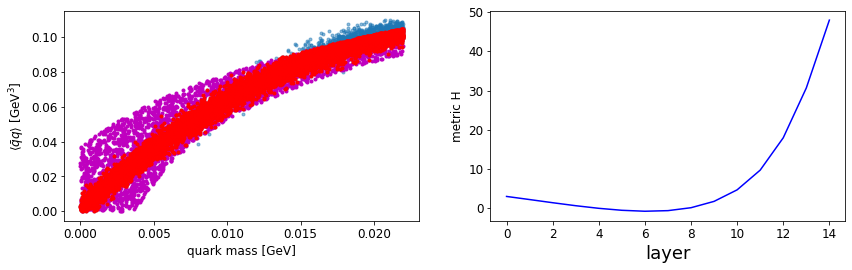

training epoch: 2200,   loss: 0.07630082964897156
lambda: 0.0061856829561293125,   AdS radius: 3.8332951068878174[1/GeV]
[ 3.0559039e+00  2.2627401e+00  1.4567895e+00  6.9317007e-01
  2.8890481e-02 -4.7220120e-01 -7.1553701e-01 -5.6142348e-01
  1.8343864e-01  1.7987809e+00  4.7367139e+00  9.7582426e+00
  1.7993595e+01  3.0683310e+01  4.7973728e+01]


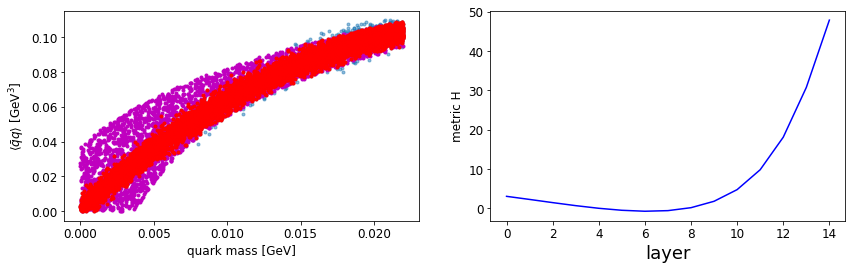

training epoch: 2300,   loss: 0.07510030269622803
lambda: 0.005711765959858894,   AdS radius: 3.803446054458618[1/GeV]
[ 3.0626893e+00  2.2731578e+00  1.4656688e+00  6.9499326e-01
  2.2987409e-02 -4.8269179e-01 -7.2752589e-01 -5.7224548e-01
  1.7770809e-01  1.8052033e+00  4.7671838e+00  9.8264160e+00
  1.8090446e+01  3.0733215e+01  4.7857037e+01]


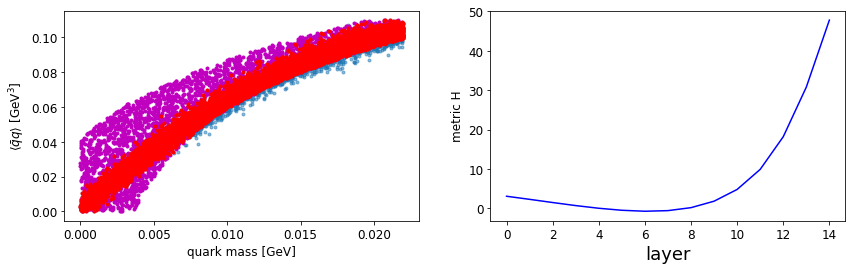

training epoch: 2400,   loss: 0.07595369219779968
lambda: 0.005264902021735907,   AdS radius: 3.8052268028259277[1/GeV]
[ 3.0678153e+00  2.2814105e+00  1.4730496e+00  6.9656736e-01
  1.7237522e-02 -4.9329451e-01 -7.3985493e-01 -5.8351254e-01
  1.7146109e-01  1.8109584e+00  4.7964611e+00  9.8913002e+00
  1.8178915e+01  3.0776917e+01  4.7791683e+01]


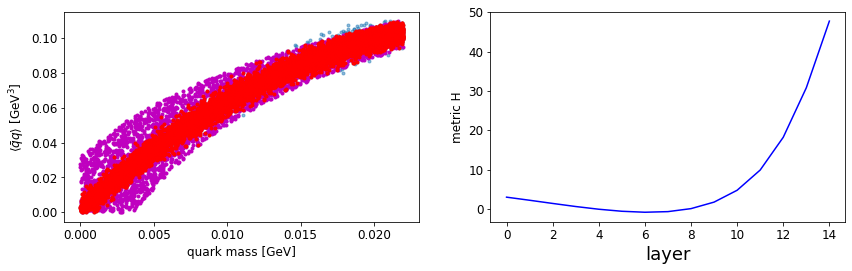

training epoch: 2500,   loss: 0.07689820975065231
lambda: 0.004600392188876867,   AdS radius: 3.810098648071289[1/GeV]
[ 3.0751443e+00  2.2916346e+00  1.4828699e+00  7.0148283e-01
  1.5156662e-02 -5.0050688e-01 -7.4907237e-01 -5.9176183e-01
  1.6824679e-01  1.8198092e+00  4.8286257e+00  9.9573517e+00
  1.8263132e+01  3.0812674e+01  4.7727974e+01]


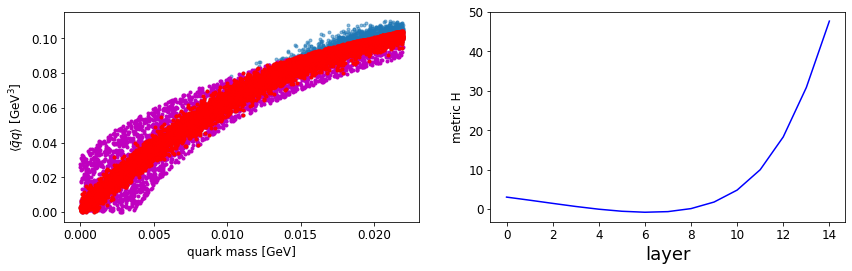

training epoch: 2600,   loss: 0.0752788707613945
lambda: 0.006032322533428669,   AdS radius: 3.8026833534240723[1/GeV]
[ 3.0791650e+00  2.2982569e+00  1.4894527e+00  7.0408130e-01
  1.1412184e-02 -5.0935447e-01 -7.6006037e-01 -6.0185808e-01
  1.6309796e-01  1.8264918e+00  4.8579435e+00  1.0018313e+01
  1.8338562e+01  3.0846394e+01  4.7698048e+01]


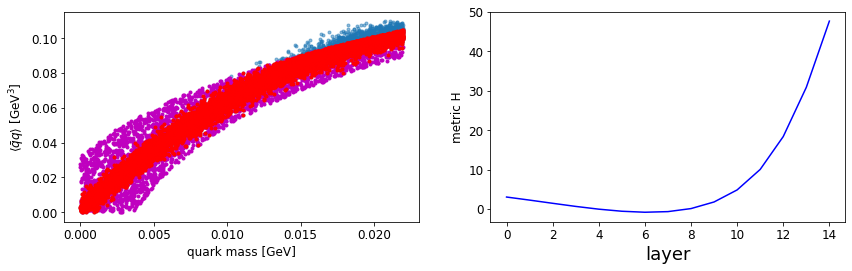

training epoch: 2700,   loss: 0.07541625201702118
lambda: 0.005810747854411602,   AdS radius: 3.8094518184661865[1/GeV]
[ 3.0831442e+00  2.3046000e+00  1.4958969e+00  7.0710796e-01
  8.4725227e-03 -5.1751399e-01 -7.7059704e-01 -6.1159003e-01
  1.5835413e-01  1.8336945e+00  4.8877201e+00  1.0078352e+01
  1.8410278e+01  3.0879274e+01  4.7667599e+01]


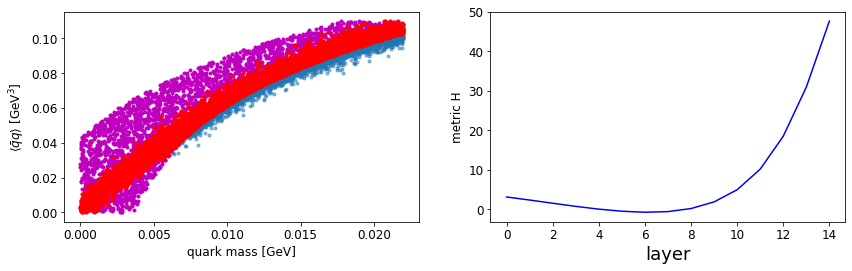

training epoch: 2800,   loss: 0.0766758844256401
lambda: 0.004857453051954508,   AdS radius: 3.791856288909912[1/GeV]
[ 3.0842566e+00  2.3078554e+00  1.4994727e+00  7.0790309e-01
  3.9690053e-03 -5.2702600e-01 -7.8255272e-01 -6.2283999e-01
  1.5193111e-01  1.8388118e+00  4.9142466e+00  1.0132558e+01
  1.8472822e+01  3.0905386e+01  4.7640579e+01]


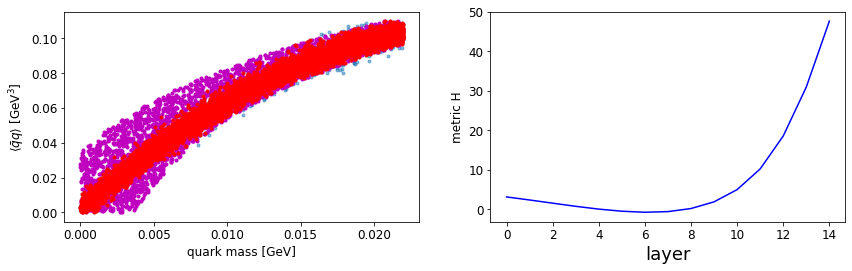

training epoch: 2900,   loss: 0.07454803586006165
lambda: 0.00481667835265398,   AdS radius: 3.794719934463501[1/GeV]
[ 3.0888827e+00  2.3143947e+00  1.5063684e+00  7.1235830e-01
  3.4145378e-03 -5.3263581e-01 -7.9080749e-01 -6.3044560e-01
  1.4929733e-01  1.8480452e+00  4.9452281e+00  1.0190802e+01
  1.8538801e+01  3.0942125e+01  4.7644596e+01]


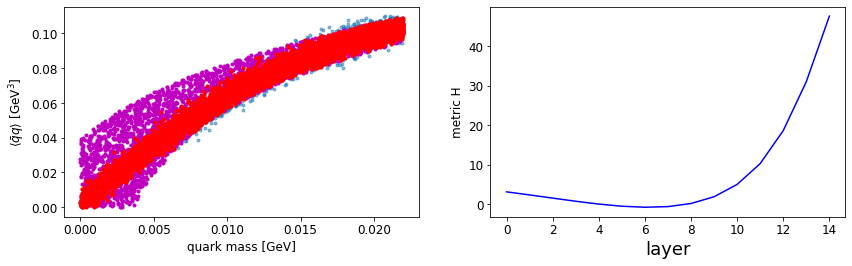

training epoch: 3000,   loss: 0.07627879828214645
lambda: 0.0061223688535392284,   AdS radius: 3.7824268341064453[1/GeV]
[ 3.0907276e+00  2.3180337e+00  1.5103720e+00  7.1421260e-01
  5.8733951e-04 -5.4049724e-01 -8.0150104e-01 -6.4066607e-01
  1.4390618e-01  1.8542835e+00  4.9723787e+00  1.0242275e+01
  1.8591999e+01  3.0951864e+01  4.7555561e+01]


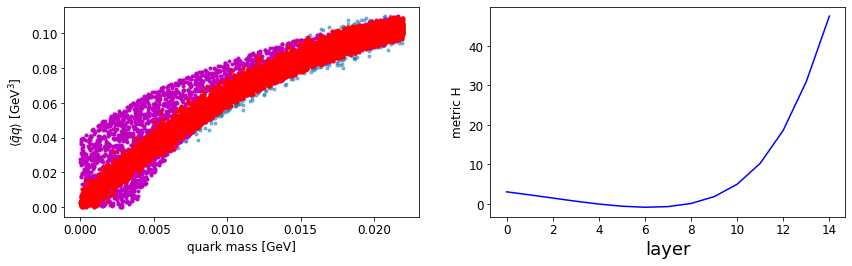

training epoch: 3100,   loss: 0.07479926943778992
lambda: 0.005773420911282301,   AdS radius: 3.7916793823242188[1/GeV]
[ 3.0933657e+00  2.3222780e+00  1.5149928e+00  7.1694946e-01
 -9.6915755e-04 -5.4693168e-01 -8.1084287e-01 -6.4959955e-01
  1.3981451e-01  1.8618357e+00  5.0005698e+00  1.0293847e+01
  1.8645399e+01  3.0971498e+01  4.7529396e+01]


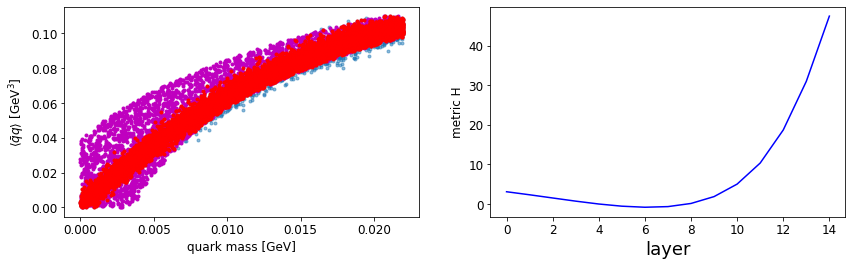

training epoch: 3200,   loss: 0.0763508528470993
lambda: 0.005293741822242737,   AdS radius: 3.78714656829834[1/GeV]
[ 3.0960495e+00  2.3265314e+00  1.5196389e+00  7.1995932e-01
 -1.9050422e-03 -5.5257040e-01 -8.1946462e-01 -6.5796679e-01
  1.3612017e-01  1.8694210e+00  5.0277457e+00  1.0341805e+01
  1.8691141e+01  3.0975967e+01  4.7449902e+01]


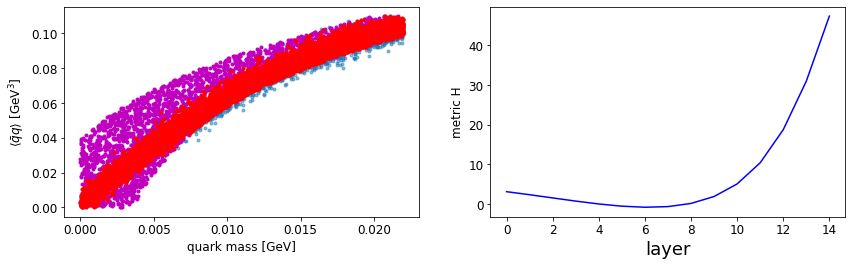

training epoch: 3300,   loss: 0.07456930726766586
lambda: 0.005462537985295057,   AdS radius: 3.7736942768096924[1/GeV]
[ 3.0980737e+00  2.3300321e+00  1.5235975e+00  7.2248685e-01
 -2.9712920e-03 -5.5813080e-01 -8.2802182e-01 -6.6635066e-01
  1.3231212e-01  1.8766694e+00  5.0538473e+00  1.0386941e+01
  1.8732569e+01  3.0977570e+01  4.7386639e+01]


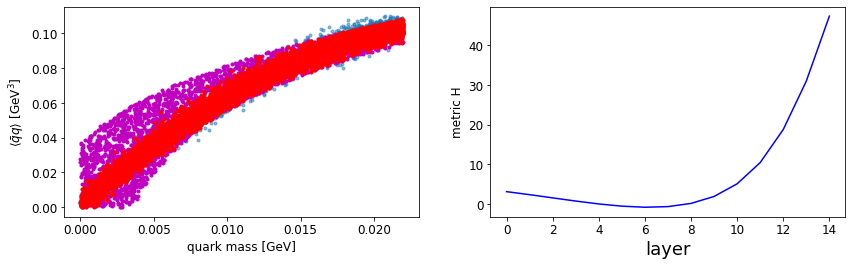

training epoch: 3400,   loss: 0.07509288191795349
lambda: 0.006117390468716621,   AdS radius: 3.7950823307037354[1/GeV]
[ 3.1001129e+00  2.3333631e+00  1.5273329e+00  7.2492635e-01
 -3.8980616e-03 -5.6340420e-01 -8.3631611e-01 -6.7451173e-01
  1.2877959e-01  1.8843037e+00  5.0803113e+00  1.0432145e+01
  1.8775833e+01  3.0994976e+01  4.7392746e+01]


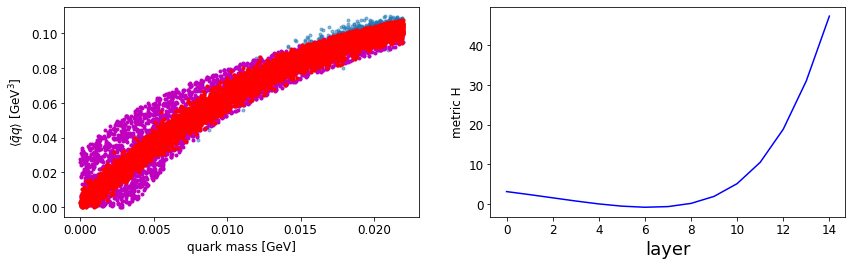

training epoch: 3500,   loss: 0.07988128811120987
lambda: 0.005752062890678644,   AdS radius: 3.7756309509277344[1/GeV]
[ 3.1030619e+00  2.3376038e+00  1.5320462e+00  7.2852612e-01
 -3.3937367e-03 -5.6706220e-01 -8.4301168e-01 -6.8119079e-01
  1.2659886e-01  1.8930058e+00  5.1069260e+00  1.0475220e+01
  1.8813438e+01  3.0997820e+01  4.7326801e+01]


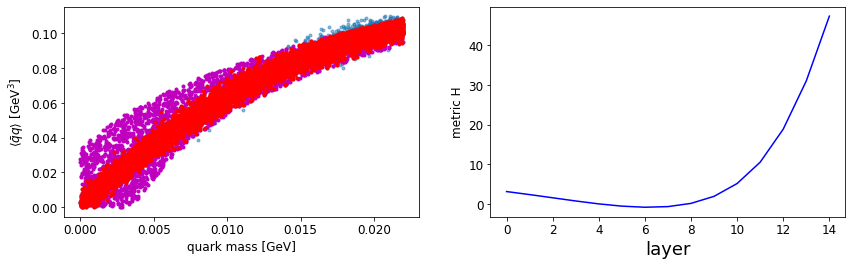

training epoch: 3600,   loss: 0.07546579837799072
lambda: 0.005691035650670528,   AdS radius: 3.780694007873535[1/GeV]
[ 3.10441327e+00  2.34000421e+00  1.53487718e+00  7.30395496e-01
 -4.33434686e-03 -5.71909130e-01 -8.50795209e-01 -6.88948691e-01
  1.23342544e-01  1.90058124e+00  5.13209343e+00  1.05166521e+01
  1.88527069e+01  3.10189667e+01  4.73521729e+01]


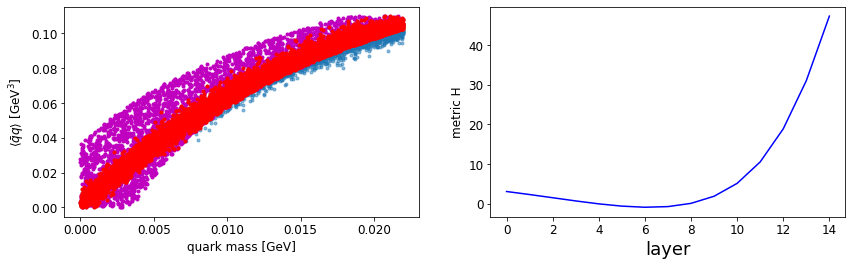

training epoch: 3700,   loss: 0.07572382688522339
lambda: 0.0041671316139400005,   AdS radius: 3.786712408065796[1/GeV]
[ 3.1059289e+00  2.3425775e+00  1.5378069e+00  7.3235494e-01
 -5.1276493e-03 -5.7661825e-01 -8.5858750e-01 -6.9687629e-01
  1.1981956e-01  1.9077632e+00  5.1562643e+00  1.0555013e+01
  1.8884212e+01  3.1016064e+01  4.7278313e+01]


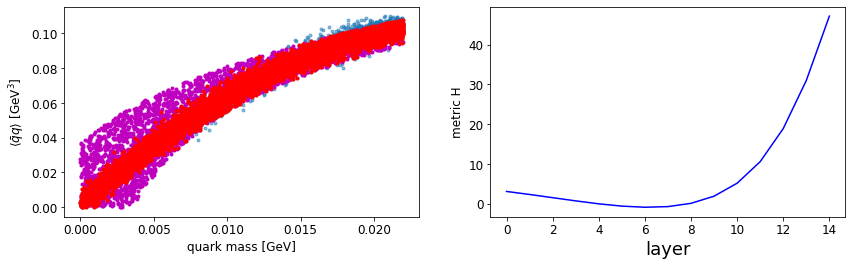

training epoch: 3800,   loss: 0.0756416767835617
lambda: 0.006358829326927662,   AdS radius: 3.7701447010040283[1/GeV]
[ 3.1071408e+00  2.3448374e+00  1.5404676e+00  7.3418254e-01
 -5.8105309e-03 -5.8097237e-01 -8.6593485e-01 -7.0443064e-01
  1.1648000e-01  1.9146844e+00  5.1791539e+00  1.0590098e+01
  1.8910419e+01  3.1004189e+01  4.7184246e+01]


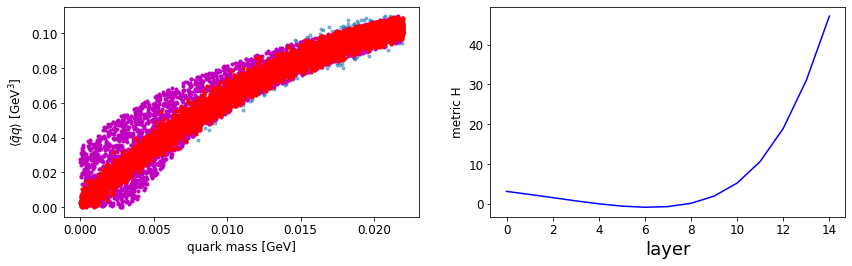

training epoch: 3900,   loss: 0.07534973323345184
lambda: 0.005347015336155891,   AdS radius: 3.785440683364868[1/GeV]
[ 3.1091568e+00  2.3478367e+00  1.5437969e+00  7.3670542e-01
 -5.6575784e-03 -5.8434278e-01 -8.7226117e-01 -7.1100485e-01
  1.1408437e-01  1.9224468e+00  5.2025061e+00  1.0625174e+01
  1.8937792e+01  3.1001490e+01  4.7152222e+01]


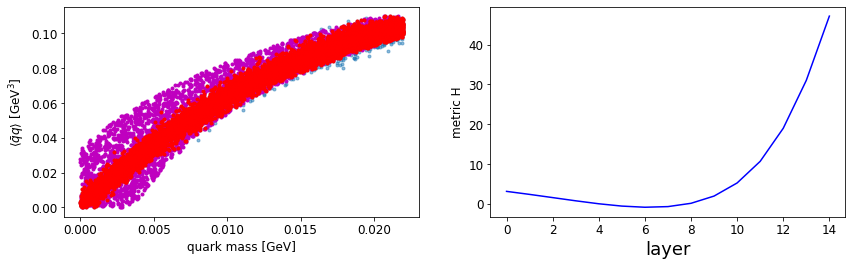

training epoch: 4000,   loss: 0.07602554559707642
lambda: 0.004777338355779648,   AdS radius: 3.766569137573242[1/GeV]
[ 3.11060405e+00  2.35021114e+00  1.54662251e+00  7.38907993e-01
 -5.58004249e-03 -5.87543786e-01 -8.78285766e-01 -7.17235506e-01
  1.12044424e-01  1.93052363e+00  5.22583961e+00  1.06598873e+01
  1.89666367e+01  3.10109882e+01  4.71593590e+01]


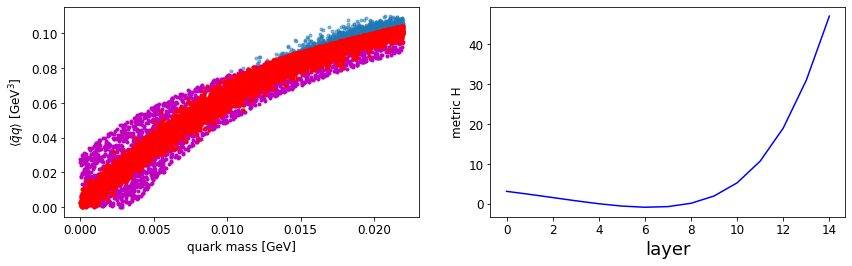

training epoch: 4100,   loss: 0.07517264783382416
lambda: 0.006246887147426605,   AdS radius: 3.756211280822754[1/GeV]
[ 3.1125610e+00  2.3529758e+00  1.5497764e+00  7.4144995e-01
 -5.0675441e-03 -5.9020853e-01 -8.8375580e-01 -7.2301066e-01
  1.1030239e-01  1.9385711e+00  5.2482862e+00  1.0692167e+01
  1.8990622e+01  3.1008099e+01  4.7111866e+01]


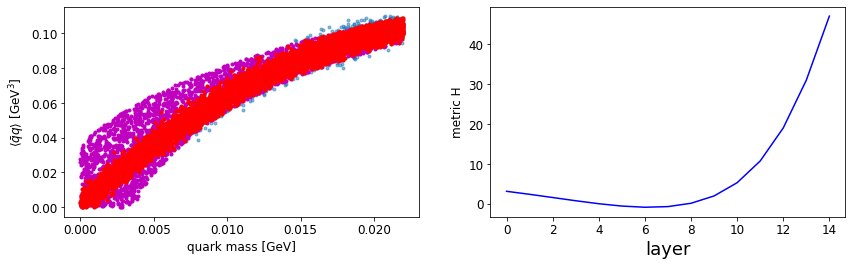

training epoch: 4200,   loss: 0.07486680150032043
lambda: 0.0059734913520514965,   AdS radius: 3.769223690032959[1/GeV]
[ 3.1121786e+00  2.3533046e+00  1.5504048e+00  7.4148113e-01
 -6.9853123e-03 -5.9521830e-01 -8.9155155e-01 -7.3111689e-01
  1.0629320e-01  1.9444706e+00  5.2686257e+00  1.0722368e+01
  1.9014538e+01  3.1014124e+01  4.7106022e+01]


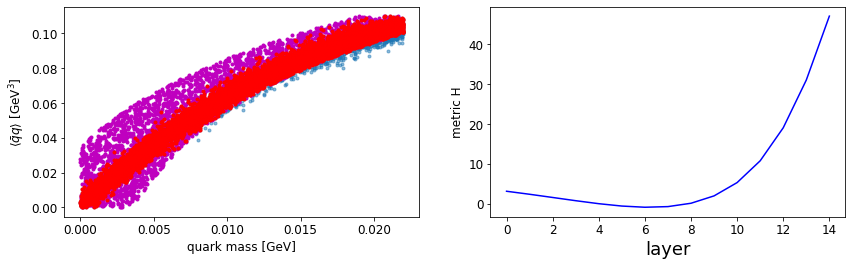

training epoch: 4300,   loss: 0.0761449933052063
lambda: 0.004476755857467651,   AdS radius: 3.7728118896484375[1/GeV]
[ 3.1139622e+00  2.3558316e+00  1.5532033e+00  7.4369776e-01
 -6.6205286e-03 -5.9782076e-01 -8.9689744e-01 -7.3686272e-01
  1.0443986e-01  1.9520715e+00  5.2896743e+00  1.0751311e+01
  1.9034235e+01  3.1004440e+01  4.7035099e+01]


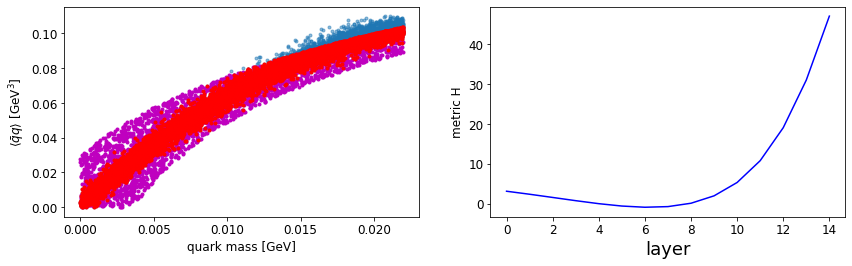

training epoch: 4400,   loss: 0.07551714032888412
lambda: 0.005938176531344652,   AdS radius: 3.787050247192383[1/GeV]
[ 3.1159396e+00  2.3584921e+00  1.5561492e+00  7.4614471e-01
 -5.8712373e-03 -5.9982920e-01 -9.0149379e-01 -7.4180120e-01
  1.0337140e-01  1.9603432e+00  5.3111172e+00  1.0780957e+01
  1.9057964e+01  3.1013079e+01  4.7050304e+01]


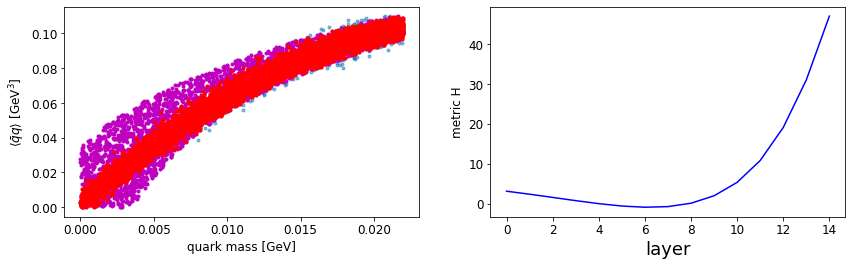

training epoch: 4500,   loss: 0.07477372884750366
lambda: 0.005546931643038988,   AdS radius: 3.7527921199798584[1/GeV]
[ 3.11560631e+00  2.35890269e+00  1.55691803e+00  7.46501744e-01
 -7.06529571e-03 -6.03623033e-01 -9.07790482e-01 -7.48473883e-01
  1.00396655e-01  1.96629071e+00  5.32930088e+00  1.08057070e+01
  1.90738850e+01  3.10040684e+01  4.70016365e+01]


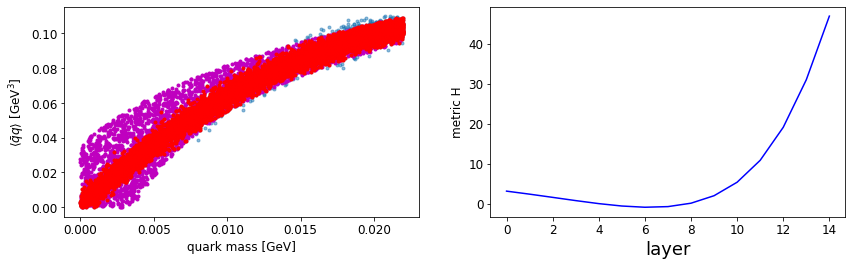

training epoch: 4600,   loss: 0.0791962742805481
lambda: 0.006168951280415058,   AdS radius: 3.747366189956665[1/GeV]
[ 3.1164660e+00  2.3603296e+00  1.5585960e+00  7.4770725e-01
 -7.4032433e-03 -6.0652548e-01 -9.1320378e-01 -7.5433397e-01
  9.8127939e-02  1.9727224e+00  5.3473873e+00  1.0829431e+01
  1.9087278e+01  3.0988129e+01  4.6906853e+01]


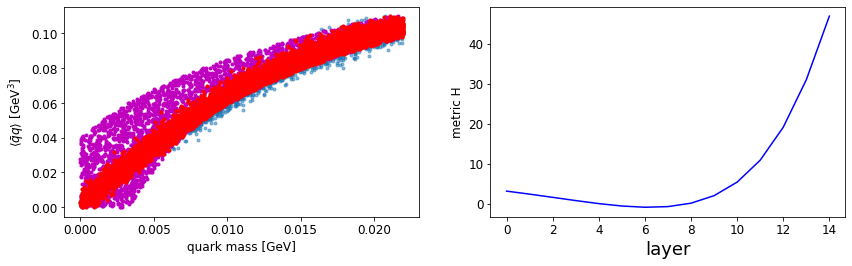

training epoch: 4700,   loss: 0.07482311129570007
lambda: 0.00604051211848855,   AdS radius: 3.7649219036102295[1/GeV]
[ 3.1162951e+00  2.3607643e+00  1.5592644e+00  7.4793702e-01
 -8.6465515e-03 -6.1022657e-01 -9.1932034e-01 -7.6084191e-01
  9.5283411e-02  1.9786884e+00  5.3650980e+00  1.0853553e+01
  1.9104637e+01  3.0990870e+01  4.6921566e+01]


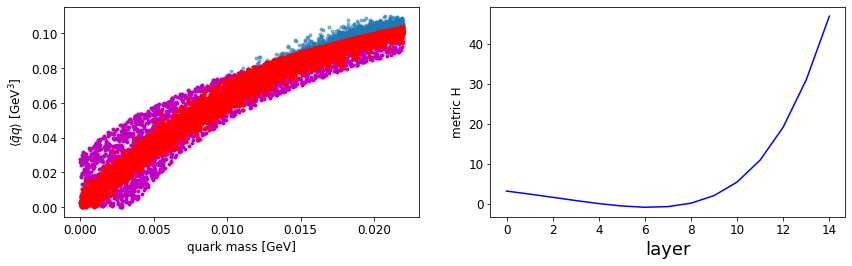

training epoch: 4800,   loss: 0.07462824136018753
lambda: 0.006470258813351393,   AdS radius: 3.759014844894409[1/GeV]
[ 3.1193128e+00  2.3643308e+00  1.5630738e+00  7.5135773e-01
 -6.5859985e-03 -6.1047322e-01 -9.2189151e-01 -7.6383787e-01
  9.5721804e-02  1.9873927e+00  5.3845153e+00  1.0877675e+01
  1.9119463e+01  3.0981476e+01  4.6869854e+01]


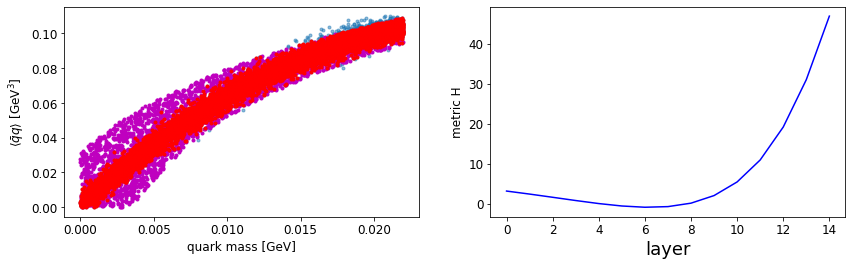

training epoch: 4900,   loss: 0.07464184612035751
lambda: 0.005195972975343466,   AdS radius: 3.7839598655700684[1/GeV]
[ 3.1199443e+00  2.3654304e+00  1.5643626e+00  7.5223428e-01
 -7.0583271e-03 -6.1323172e-01 -9.2694646e-01 -7.6929110e-01
  9.3824908e-02  1.9939964e+00  5.4021087e+00  1.0900698e+01
  1.9136078e+01  3.0986141e+01  4.6881981e+01]


In [21]:
negx, negy, posx, posy, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test)
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]))

In [22]:
print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]))

[ 3.1204014e+00  2.3664553e+00  1.5656942e+00  7.5330108e-01
 -7.1254643e-03 -6.1530268e-01 -9.3107760e-01 -7.7378535e-01
  9.2598118e-02  2.0005224e+00  5.4184060e+00  1.0921110e+01
  1.9148993e+01  3.0982252e+01  4.6855743e+01]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [0]:
%%bash
mkdir trained_models

mkdir: trained_models: File exists


Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [0]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [0]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [0]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

array([[ 3.85264516]], dtype=float32)

In [0]:
model.lamb.weight.data.numpy() # lambda

array([[ 0.00545012]], dtype=float32)

In [0]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)

[[ 3.13351607]]
[[ 2.39271212]]
[[ 1.60696924]]
[[ 0.8100372]]
[[ 0.06195514]]
[[-0.5439406]]
[[-0.87814671]]
[[-0.77317631]]
[[-0.00735563]]
[[ 1.74285817]]
[[ 4.97534227]]
[[ 10.37840176]]
[[ 18.70586967]]
[[ 30.80181313]]
[[ 46.99329758]]
